In [1]:
import pandas as pd
import io
import requests
from datetime import datetime
from collections import defaultdict

import matplotlib.pyplot as plt

def loadfiles():
    prefix = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
    filenames={'confirmed':'time_series_19-covid-Confirmed.csv',
       'deaths':'time_series_19-covid-Deaths.csv',
       'recovered':'time_series_19-covid-Recovered.csv'}
    result={}
    for file in filenames.keys():
        url = prefix+filenames[file]
        s=requests.get(url).content
        result[file]=pd.read_csv(io.StringIO(s.decode('utf-8')))
    return result
files = loadfiles()
        

In [2]:
def transform_vals(files,name):
    values = defaultdict(list)
    df = files[name]
    dates = [datetime.strptime(d,'%m/%d/%y') for d in df.columns[4:]]
    for row in df.iterrows():
        vals = row[1][4:]
        province_state = row[1][0]
        country = row[1][1]
        lat = row[1][2]
        lon = row[1][3]
        for i in range(len(vals)):
            values['province_state'].append(province_state)
            values['country'].append(country)
            values['lat'].append(lat)
            values['lon'].append(lon)
            values['date'].append(dates[i])
            values[name].append(vals[i])
    return values

def loadDF(files):
    values = transform_vals(files,'confirmed')
    values['deaths']=transform_vals(files,'deaths')['deaths']
    values['recovered']=transform_vals(files,'recovered')['recovered']
    return pd.DataFrame.from_dict(values)
df = loadDF(files)
df.to_csv('data.csv')
del df['lat']
del df['lon']

displaydate = max(df['date'])
#displaydate = '2020/01/27'
df[df['date']==displaydate].groupby(['country']).sum().sort_values(by=['confirmed'], ascending=False)

,confirmed,deaths,recovered
country,,,
Mainland China,80652,3070,55478
South Korea,7041,44,135
Italy,5883,233,589
Iran,5823,145,1669
France,949,11,12
Germany,799,0,18
Others,696,6,40
Spain,500,10,30
Japan,461,6,76


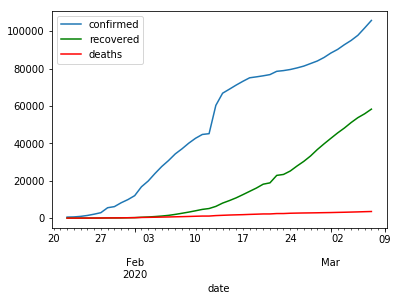

In [3]:
def plotvals(df):
    df=df.groupby(['date']).sum()
    ax = plt.gca()
    df.plot(kind='line',y='confirmed',ax=ax)
    df.plot(kind='line',y='recovered',color='green', ax=ax)
    df.plot(kind='line',y='deaths', color='red', ax=ax)
    plt.show()
    
plotvals(df)

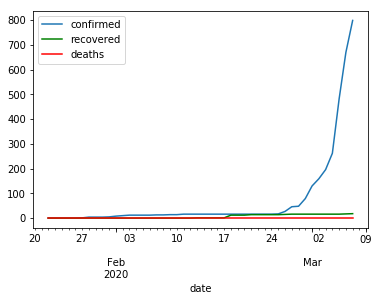

In [4]:
plotvals(df[df['country']=='Germany'])

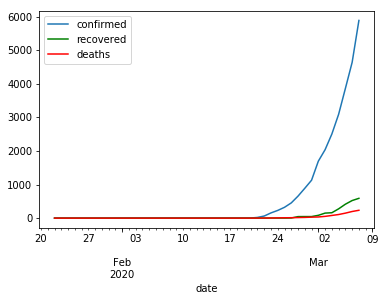

In [5]:
plotvals(df[df['country']=='Italy'])

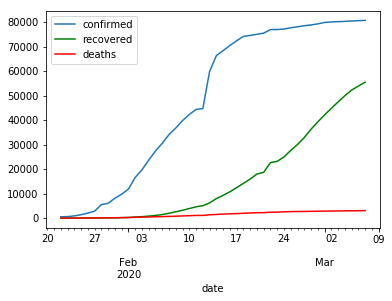

In [6]:
plotvals(df[df['country']=='Mainland China'])

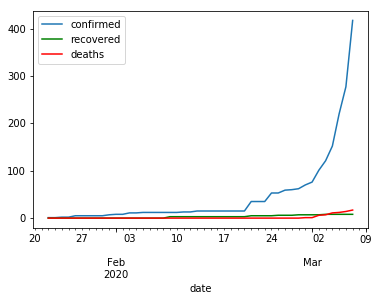

In [7]:
plotvals(df[df['country']=='US'])